Importing Libraries

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

In [109]:
raw_apple = '63101000'     
maraschino_cherry = '63111010'     
margarine = '81102000'     
yeast = '75236000'         
raw_oyester = '26315100'   

thiamin = '404'                     
protein = '203'         
gadoleic_acid = '617'  
zinc = '309' 

Function for converting milligrams, micrograms to grams

In [110]:
def convert_to_grams(row):
    if row['Unit'] == 'mg':
        return row['Amount'] / 1000
    elif row['Unit'] == 'mcg':
        return row['Amount'] / 1000000
    elif row['Unit'] == 'g':
        return row['Amount']
    else:
        return 0

Function for calculating logarithmic standard deviation

In [111]:

def standard_deviation(data,nutrient):
    log_avg = 0
    log_avg_sq = 0
    c=0
    for j in data:
        if(j[1]==int(nutrient)):
            if((j[4]) == 0):
                # c+=1 
                continue
            log_avg += np.log(float(j[4]))
            log_avg_sq += np.log(float(j[4]))**2
            c+=1
    # print(c2)
    # print("c:",c)
    # if(c==0):
    #     return 0
    return ((log_avg_sq/c) - ((log_avg/c)**2))**0.5

Function for calculating mn

In [112]:
def mn_calculator(linear_average_conc,sn):
    # if(linear_average_conc==0):
    #     return 0
    mn = np.log(linear_average_conc) - (sn**2)/2
    return mn

In [113]:
def linear_average_concentration(data,nutrient):
    num=0
    den=0
    for i in data:
        if(i[1]==int(nutrient)):
            num+=i[4]
            den+=1
    if(den==0):
        return 0
    return num/den

Function for calculating qn

In [114]:
def qn_calculator(xn, data, nutrient):
    sn = standard_deviation(data,nutrient)
    mewn = linear_average_concentration(data,nutrient)
    mn = mn_calculator(mewn,sn)
    bracket = -1*((((np.log(xn)-mn))**2)/(2*sn**2))
    numerator = np.exp(bracket)
    denominator = (xn * sn) * (np.sqrt(2*np.pi)) 
    if(denominator==0):
        return 0
    return numerator/denominator

Function for pivoting the dataset

In [115]:
def pivot_dataset(df):
    df.drop(columns=["Nutrient Index", "Unit", "Decimal Places"])
    df = df[df["Nutrient Index"].isin([309, 404])]

    df = df.pivot_table(index=['Food Index', 'Food'], columns='Nutrient Index', values='Amount', aggfunc='sum').reset_index()
    df.columns = ['Food Index', 'Food', 'Zinc', 'Thiamin']
    
    return df

Function for calculating the skewness

In [116]:
#skewness
def skewness(data, nutrient):
    log_values = []
    n = 0
    for item in data:
        if item[1] == int(nutrient):
            value = item[4]
            if value != 0:
                log_values.append(np.log(value))
                n += 1
    if n < 3:
        return None  # Skewness is undefined for less than 3 data points

    mean = np.mean(log_values)
    std_dev = np.std(log_values, ddof=1)  # Use ddof=1 for sample standard deviation
    skewness = (n / ((n - 1) * (n - 2))) * np.sum(((log_values - mean) / std_dev) ** 3)
    return skewness


In [117]:
def x_axis(st,end):
    x_axis = np.logspace(st, end, num=20)
    log_x_axis = np.log10(x_axis)


    # x_axis_str = ', '.join(map(str, log_x_axis))
    x_axis_str = ', '.join(map(str, x_axis))
    x_axis=[]
    for i in x_axis_str.split(", "):
        x_axis.append(float(i))

    return x_axis

In [118]:
def rescale_data(y_coordinates, nutrient, data):
    sn = standard_deviation(data, nutrient)
    mn = mn_calculator(linear_average_concentration(data, nutrient), sn)
    
    rescaled_y = []
    for yi in y_coordinates:
        log_y = np.log(yi)  
        rescaled_yi = np.exp(log_y - mn) 
        rescaled_y.append(rescaled_yi)
    
    return rescaled_y

In [119]:
def min_max_normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    normalized = [(x - min_val) / (2*(max_val - min_val)) for x in lst]
    return normalized

In [120]:
def graph_plot_one(nutrient, x_axis,qn, fig_name):
    if nutrient == '309':
        graph = 'Zinc'
    elif nutrient == '404':
        graph = 'Thiamin'
    else:
        graph = nutrient
        
    plt.plot(x_axis, qn, marker='o')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.title(f'{fig_name} {graph}')
    plt.xlabel('x_axis')
    plt.ylabel('qn')
    plt.show()

Loading both the days data and removing the rows which have baby food

In [121]:
first_day = pd.read_csv("../NHANES/NHANES Original/CSV/firstDay.csv")
first_day = first_day[first_day["DRABF"] != 1]
second_day = pd.read_csv("../NHANES/NHANES Original/CSV/secondDay.csv")
second_day = second_day[second_day["DRABF"] != 1]

Selecting the USDA food indices from both the days 

In [122]:
first_day = set(first_day["DR1IFDCD"].tolist())
second_day = set(second_day["DR2IFDCD"].tolist())

both_days = list(first_day) + list(second_day)
len(set(both_days))

4968

Loading the FNDDS and Flavonoids dataset, and creating the NHANES dataset (The part that the paper is observing)

In [123]:
FNDDS_df = pd.read_csv('CSVs/FNDDS.csv')
Flavonoids_df = pd.read_csv('CSVs/Flavonoids.csv')

FNDDS_and_Flavs = pd.concat([FNDDS_df, Flavonoids_df],ignore_index=True)
NHANES_df = FNDDS_and_Flavs[FNDDS_and_Flavs["Food Index"].isin(both_days)]
NHANES_df = NHANES_df[NHANES_df.Amount !=0]
NHANES_df

,Food Index,Nutrient Index,From,To,Amount,Nutrient,Nutrient Code,Unit,Decimal Places,Food,Nutrient Category
65,11100000,203,01/01/2009,12/31/2010,3.28,Protein,PROCNT,g,2,"~Milk, NFS~",NaN
66,11100000,204,01/01/2009,12/31/2010,1.91,Total Fat,FAT,g,2,"~Milk, NFS~",NaN
67,11100000,205,01/01/2009,12/31/2010,4.85,Carbohydrate,CHOCDF,g,2,"~Milk, NFS~",NaN
68,11100000,208,01/01/2009,12/31/2010,50.00,Energy,ENERC_KCAL,kcal,0,"~Milk, NFS~",NaN
70,11100000,255,01/01/2009,12/31/2010,89.25,Water,WATER,g,2,"~Milk, NFS~",NaN
...,...,...,...,...,...,...,...,...,...,...,...
740206,93504100,7100,01/01/2007,12/31/2010,15.49,Total anthocyanidins,,mg,2,NaN,Anthocyanidins
740207,93504100,7200,01/01/2007,12/31/2010,6.13,Total catechins (monomeric flavan-3-ols only),,mg,2,NaN,Flavan-3-ols
740208,93504100,7300,01/01/2007,12/31/2010,6.13,Total flavan-3-ols,,mg,2,NaN,Flavan-3-ols
740209,93504100,7400,01/01/2007,12/31/2010,1.16,Total flavanones,,mg,2,NaN,Flavanones


Dropping the columns (irrelevant for the analysis)

In [124]:
FNDDS_df.drop(columns = ['From','To','Nutrient Code'], inplace=True)
Flavonoids_df.drop(columns = ['From','To','Nutrient Code'], inplace=True)

All nutrients present in "Raw Apple"

In [125]:
# figure1_a = FNDDS_df
figure1_a = pd.concat([FNDDS_df, Flavonoids_df], ignore_index=True)
figure1_a.drop(columns = ['Food','Nutrient Category'],inplace= True)
figure1_a['Amount'] = figure1_a.apply(convert_to_grams, axis = 1)
figure1_a = figure1_a[figure1_a['Food Index'] == 63101000]
figure1_a = figure1_a[figure1_a['Amount'] != 0].sort_values(by='Amount', ascending=False)
figure1_a

,Food Index,Nutrient Index,Amount,Nutrient,Unit,Decimal Places
317595,63101000,255,85.560000,Water,g,2
317592,63101000,205,13.810000,Carbohydrate,g,2
317598,63101000,269,10.390000,"Sugars, total",g,2
317599,63101000,291,2.400000,"Fiber, total dietary",g,1
317590,63101000,203,0.260000,Protein,g,2
317591,63101000,204,0.170000,Total Fat,g,2
317604,63101000,306,0.107000,Potassium,mg,0
317654,63101000,646,0.051000,"Fatty acids, total polyunsaturated",g,3
317643,63101000,618,0.043000,18:2,g,3
317633,63101000,606,0.028000,"Fatty acids, total saturated",g,3


Plotting Figure 1a

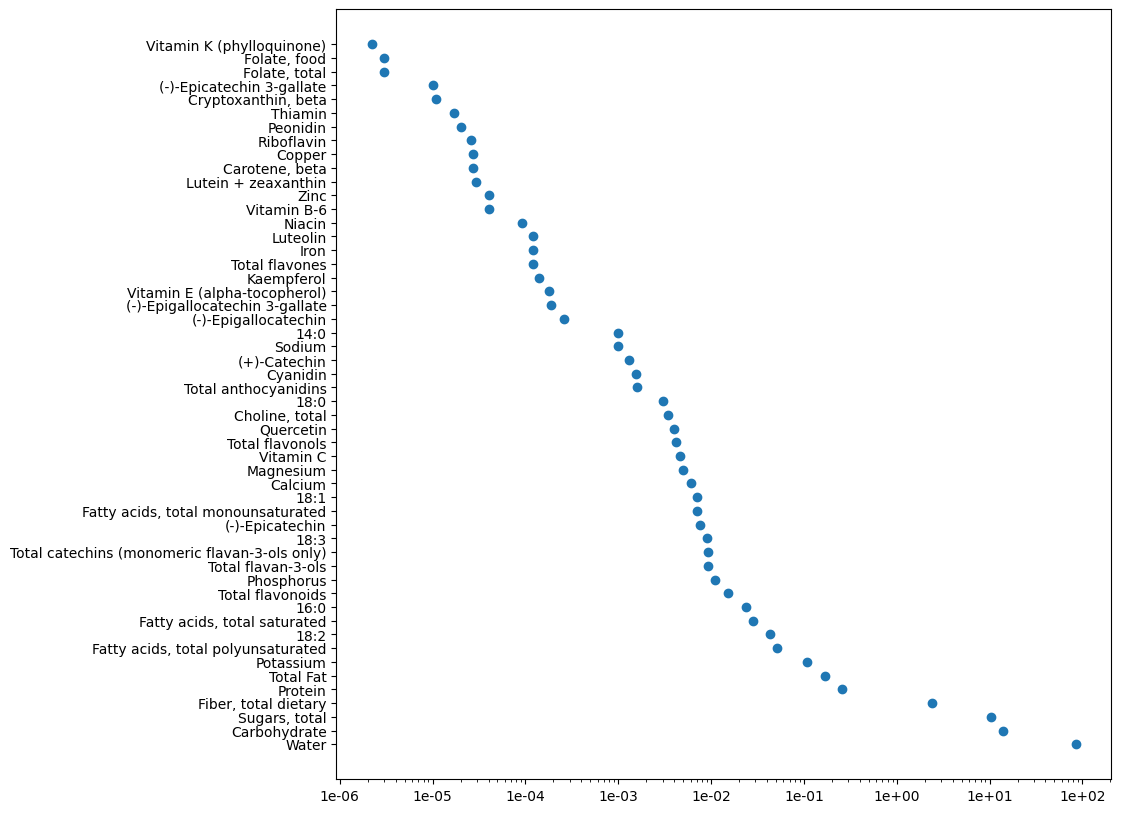

In [126]:
plt.figure(figsize=(10, 10))
plt.scatter(figure1_a['Amount'], figure1_a['Nutrient'], marker='o')
x_ticks = [10**i for i in range(-6, 3)]
plt.xscale('log')
plt.xticks(x_ticks, [f"{val:.0e}" for val in x_ticks])
plt.show()

Amount of "Zinc" and "Thiamin" present in the five foods : raw oysters, raw apple, maraschino cherries, yeast and margarine (Figure1b) 

In [127]:
figure1_b = FNDDS_df
figure1_b = figure1_b[figure1_b['Food Index'].isin([63101000, 63111010, 81102000, 75236000, 26315100])]
figure1_b = figure1_b[figure1_b['Nutrient Index'].isin([404, 309, 603, 217])]
figure1_b

,Food Index,Nutrient Index,Amount,Nutrient,Unit,Decimal Places,Food
92576,26315100,309,39.300,Zinc,mg,2,"~Oysters, raw~"
92589,26315100,404,0.018,Thiamin,mg,3,"~Oysters, raw~"
317606,63101000,309,0.040,Zinc,mg,2,"~Apple, raw~"
317619,63101000,404,0.017,Thiamin,mg,3,"~Apple, raw~"
319881,63111010,309,0.260,Zinc,mg,2,"~Cherries, maraschino~"
319894,63111010,404,0.000,Thiamin,mg,3,"~Cherries, maraschino~"
403796,75236000,309,7.940,Zinc,mg,2,~Yeast~
403809,75236000,404,10.990,Thiamin,mg,3,~Yeast~
428561,81102000,309,0.000,Zinc,mg,2,"~Margarine, NFS~"
428574,81102000,404,0.007,Thiamin,mg,3,"~Margarine, NFS~"


In [128]:
figure1_b["Amount"] = figure1_b.apply(convert_to_grams, axis = 1)
figure1_b #Zinc = 0.04754g

,Food Index,Nutrient Index,Amount,Nutrient,Unit,Decimal Places,Food
92576,26315100,309,0.039300,Zinc,mg,2,"~Oysters, raw~"
92589,26315100,404,0.000018,Thiamin,mg,3,"~Oysters, raw~"
317606,63101000,309,0.000040,Zinc,mg,2,"~Apple, raw~"
317619,63101000,404,0.000017,Thiamin,mg,3,"~Apple, raw~"
319881,63111010,309,0.000260,Zinc,mg,2,"~Cherries, maraschino~"
319894,63111010,404,0.000000,Thiamin,mg,3,"~Cherries, maraschino~"
403796,75236000,309,0.007940,Zinc,mg,2,~Yeast~
403809,75236000,404,0.010990,Thiamin,mg,3,~Yeast~
428561,81102000,309,0.000000,Zinc,mg,2,"~Margarine, NFS~"
428574,81102000,404,0.000007,Thiamin,mg,3,"~Margarine, NFS~"


The observed part of the FNDDS dataset (should be 7253)

In [129]:
observed_df = FNDDS_df
observed_df = pivot_dataset(observed_df)

observed_df

,Food Index,Food,Zinc,Thiamin
0,11000000,"~Milk, human~",0.17,0.014
1,11100000,"~Milk, NFS~",0.43,0.040
2,11111000,"~Milk, cow's, fluid, whole~",0.37,0.046
3,11111100,"~Milk, cow's, fluid, whole, low-sodium~",0.38,0.020
4,11111150,"~Milk, calcium fortified, cow's, fluid, whole~",0.37,0.046
...,...,...,...,...
7248,94100200,"~Water, bottled, sweetened, with low or no cal...",0.00,0.000
7249,94100300,"~Water, fruit flavored, sweetened, with high f...",0.32,0.000
7250,94210100,~Propel Water~,0.00,0.000
7251,94210200,~Glaceau Water~,0.32,0.000


Observed part without the foods consumed by babies (should be 4889)

In [130]:
no_baby_df = pivot_dataset(NHANES_df)
zinc_total = no_baby_df["Zinc"].sum()
print(zinc_total)
no_baby_df

7003.610000000001


,Food Index,Food,Zinc,Thiamin
0,11100000,"~Milk, NFS~",0.43,0.040
1,11111000,"~Milk, cow's, fluid, whole~",0.37,0.046
2,11111160,"~Milk, calcium fortified, cow's, fluid, 1% fat~",0.42,0.020
3,11111170,"~Milk, calcium fortified, cow's, fluid, skim o...",0.40,0.036
4,11112110,"~Milk, cow's, fluid, 2% fat~",0.48,0.039
...,...,...,...,...
4919,93505000,~Vodka~,0.04,0.006
4920,94000000,~Water as an ingredient~,0.01,NaN
4921,94000100,"~Water, tap~",0.01,NaN
4922,94100300,"~Water, fruit flavored, sweetened, with high f...",0.32,NaN


Converted the data amount of nutrients in food to grams and stored it in a dataframe

In [131]:
data = NHANES_df
data["Amount"] = data.apply(convert_to_grams, axis = 1)
data = data[data['Unit'].isin(["g","mg","mcg"])]
data

,Food Index,Nutrient Index,From,To,Amount,Nutrient,Nutrient Code,Unit,Decimal Places,Food,Nutrient Category
65,11100000,203,01/01/2009,12/31/2010,3.28000,Protein,PROCNT,g,2,"~Milk, NFS~",NaN
66,11100000,204,01/01/2009,12/31/2010,1.91000,Total Fat,FAT,g,2,"~Milk, NFS~",NaN
67,11100000,205,01/01/2009,12/31/2010,4.85000,Carbohydrate,CHOCDF,g,2,"~Milk, NFS~",NaN
70,11100000,255,01/01/2009,12/31/2010,89.25000,Water,WATER,g,2,"~Milk, NFS~",NaN
73,11100000,269,01/01/2009,12/31/2010,5.08000,"Sugars, total",SUGAR,g,2,"~Milk, NFS~",NaN
...,...,...,...,...,...,...,...,...,...,...,...
740206,93504100,7100,01/01/2007,12/31/2010,0.01549,Total anthocyanidins,,mg,2,NaN,Anthocyanidins
740207,93504100,7200,01/01/2007,12/31/2010,0.00613,Total catechins (monomeric flavan-3-ols only),,mg,2,NaN,Flavan-3-ols
740208,93504100,7300,01/01/2007,12/31/2010,0.00613,Total flavan-3-ols,,mg,2,NaN,Flavan-3-ols
740209,93504100,7400,01/01/2007,12/31/2010,0.00116,Total flavanones,,mg,2,NaN,Flavanones


Storing the dataframe values in a list for ease of use

In [132]:
data_list = data.values.tolist()
data_list

[[11100000,
  203,
  '01/01/2009',
  '12/31/2010',
  3.28,
  'Protein',
  'PROCNT',
  'g',
  2,
  '~Milk, NFS~',
  nan],
 [11100000,
  204,
  '01/01/2009',
  '12/31/2010',
  1.91,
  'Total Fat',
  'FAT',
  'g',
  2,
  '~Milk, NFS~',
  nan],
 [11100000,
  205,
  '01/01/2009',
  '12/31/2010',
  4.85,
  'Carbohydrate',
  'CHOCDF',
  'g',
  2,
  '~Milk, NFS~',
  nan],
 [11100000,
  255,
  '01/01/2009',
  '12/31/2010',
  89.25,
  'Water',
  'WATER',
  'g',
  2,
  '~Milk, NFS~',
  nan],
 [11100000,
  269,
  '01/01/2009',
  '12/31/2010',
  5.08,
  'Sugars, total',
  'SUGAR',
  'g',
  2,
  '~Milk, NFS~',
  nan],
 [11100000,
  301,
  '01/01/2009',
  '12/31/2010',
  0.119,
  'Calcium',
  'CA',
  'mg',
  0,
  '~Milk, NFS~',
  nan],
 [11100000,
  303,
  '01/01/2009',
  '12/31/2010',
  2.9999999999999997e-05,
  'Iron',
  'FE',
  'mg',
  2,
  '~Milk, NFS~',
  nan],
 [11100000,
  304,
  '01/01/2009',
  '12/31/2010',
  0.011,
  'Magnesium',
  'MG',
  'mg',
  0,
  '~Milk, NFS~',
  nan],
 [11100000,
  3

In [133]:
for i in data_list:
    if i[0] == 63111010:
        if i[1] == int(zinc):
            print(i)

[63111010, 309, '01/01/2009', '12/31/2010', 0.00026000000000000003, 'Zinc', 'ZN', 'mg', 2, '~Cherries, maraschino~', nan]


In [162]:
figure1_b_list = figure1_b.values.tolist()
figure1_b_list

[[26315100, 309, 0.039299999999999995, 'Zinc', 'mg', 2, '~Oysters, raw~'],
 [26315100, 404, 1.7999999999999997e-05, 'Thiamin', 'mg', 3, '~Oysters, raw~'],
 [63101000, 309, 4e-05, 'Zinc', 'mg', 2, '~Apple, raw~'],
 [63101000, 404, 1.7e-05, 'Thiamin', 'mg', 3, '~Apple, raw~'],
 [63111010,
  309,
  0.00026000000000000003,
  'Zinc',
  'mg',
  2,
  '~Cherries, maraschino~'],
 [63111010, 404, 0.0, 'Thiamin', 'mg', 3, '~Cherries, maraschino~'],
 [75236000, 309, 0.007940000000000001, 'Zinc', 'mg', 2, '~Yeast~'],
 [75236000, 404, 0.01099, 'Thiamin', 'mg', 3, '~Yeast~'],
 [81102000, 309, 0.0, 'Zinc', 'mg', 2, '~Margarine, NFS~'],
 [81102000, 404, 7e-06, 'Thiamin', 'mg', 3, '~Margarine, NFS~']]

In [167]:
counts = []
for i in data_list:
    if i[1] == int(thiamin):
        count = 0
        for j in figure1_b_list:
            if i[1] == int(thiamin) and j[1] == int(thiamin):
                if i[4] >= j[2]:
                    count += 1
        counts.append(count)

counts

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [168]:
c = 0
zinc_c =0
for i in data_list:
    if i[5] == 'Zinc':
        zinc_c+=1
        if i[4] >= 0.00794 :
            c+=1
        if i[4] == 0:
            print("zero")

print(zinc_c)

#0.9635 thiamin
#0.9861 zinc
c

4899


101

Finding the unique nutrient indices

In [135]:
unique_nuts = []
for i in data_list:
    unique_nuts.append(i[1])

unique_nuts = list(set(unique_nuts))

Storing the standard deviation of all the nutrients (99) across all foods (4968)

In [136]:
sd_nutrient_dict = {}

for i in unique_nuts:
    sd_nutrient_dict[i] = standard_deviation(data_list,i)

sd_nutrient_dict

{7700: 2.6058236704446163,
 7200: 1.9031969171689527,
 573: 1.5978604780998158,
 578: 1.4567321970034124,
 601: 1.3501148420672946,
 606: 1.9478960960268896,
 607: 2.0593067720715106,
 608: 1.5136620882286058,
 609: 1.7821503215587098,
 610: 1.9615561947217937,
 611: 2.0176628398233767,
 612: 2.0670746267788003,
 613: 1.8001912427812075,
 614: 2.07749686616594,
 617: 2.1002331173044397,
 618: 1.8161941365673087,
 619: 1.464592330603633,
 620: 1.2749372497373808,
 621: 1.6185035477666163,
 626: 1.9311879585116234,
 627: 1.4700229757779817,
 628: 1.3568377532283025,
 629: 1.6259572071407153,
 630: 1.5866138725379537,
 631: 1.1317464680486267,
 7300: 1.9381728401552312,
 645: 2.128787395872369,
 646: 1.736343724039256,
 710: 2.5638394653895866,
 711: 2.526274627590903,
 712: 2.0901119668091797,
 203: 1.3450027170698398,
 204: 1.702405105581027,
 205: 1.2483257637900538,
 731: 1.9505299266735503,
 221: 1.9651110532854958,
 740: 2.0497595295359696,
 741: 2.3570542718226863,
 742: 2.26115131

In [137]:
five_food_df = data[data["Food Index"].isin([63101000, 63111010, 81102000, 75236000, 26315100])]
five_food_df

,Food Index,Nutrient Index,From,To,Amount,Nutrient,Nutrient Code,Unit,Decimal Places,Food,Nutrient Category
92560,26315100,203,01/01/2009,12/31/2010,5.71000,Protein,PROCNT,g,2,"~Oysters, raw~",NaN
92561,26315100,204,01/01/2009,12/31/2010,1.71000,Total Fat,FAT,g,2,"~Oysters, raw~",NaN
92562,26315100,205,01/01/2009,12/31/2010,2.72000,Carbohydrate,CHOCDF,g,2,"~Oysters, raw~",NaN
92565,26315100,255,01/01/2009,12/31/2010,89.04000,Water,WATER,g,2,"~Oysters, raw~",NaN
92568,26315100,269,01/01/2009,12/31/2010,0.62000,"Sugars, total",SUGAR,g,2,"~Oysters, raw~",NaN
...,...,...,...,...,...,...,...,...,...,...,...
652590,63101000,7100,01/01/2007,12/31/2010,0.00159,Total anthocyanidins,,mg,2,NaN,Anthocyanidins
652591,63101000,7200,01/01/2007,12/31/2010,0.00929,Total catechins (monomeric flavan-3-ols only),,mg,2,NaN,Flavan-3-ols
652592,63101000,7300,01/01/2007,12/31/2010,0.00929,Total flavan-3-ols,,mg,2,NaN,Flavan-3-ols
652594,63101000,7500,01/01/2007,12/31/2010,0.00012,Total flavones,,mg,2,NaN,Flavones


In [138]:
five_food_list = five_food_df.values.tolist()

In [139]:
thiamin_list = []
zinc_list = []

for i in five_food_list:
    if(i[1] == 404):
        thiamin_list.append(i[4])
    if(i[1] == 309):
        zinc_list.append(i[4])


In [140]:
print(thiamin_list)
print(zinc_list)

[1.7999999999999997e-05, 1.7e-05, 0.01099, 7e-06]
[0.039299999999999995, 4e-05, 0.00026000000000000003, 0.007940000000000001]


In [141]:
data_fourfood = data.values.tolist()
print(len(data_fourfood))

235606


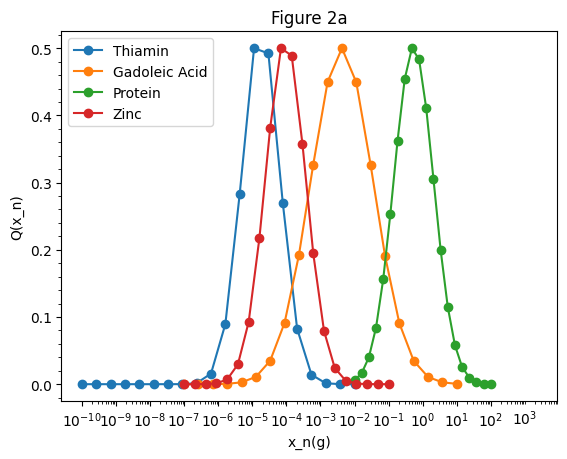

In [142]:


def graph_plot(nutrients, x_axis_data, qn_data, fig_name):
    plt.figure()  # Create a new figure for each plot

    for nutrient, qn in qn_data.items():
        if nutrient == '309':
            graph = 'Zinc'
        elif nutrient == '404':
            graph = 'Thiamin'
        else:
            graph = nutrient  
        
        plt.plot(x_axis_data[nutrient], qn, marker='o', label=graph)

    plt.xscale('log') 
    # plt.yscale('log')  
    # plt.ylim(0, 1)  
    yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    xticks =  [10**i for i in range(-10, 3)]
    plt.yticks(yticks)
    plt.xticks(xticks)
    plt.minorticks_on()
    minor_ticks = []
    for i in range(-10, 4):
        for j in range(1, 10):
            minor_ticks.append(10**i * j)
    plt.gca().xaxis.set_ticks(minor_ticks, minor=True)
    # plt.gca().xaxis.set_minor_locator(ticker.LogLocator(subs='all'))

    plt.title(fig_name)
    plt.xlabel('x_n(g)')
    plt.ylabel('Q(x_n)')
    plt.legend()  
    
    plt.show()



x_axis_data={}
x_axis_data['Thiamin'] = x_axis(-10,-2)
x_axis_data['Zinc'] = x_axis(-7,-1)
x_axis_data['Gadoleic Acid'] = x_axis(-7,1) 
x_axis_data['Protein'] = x_axis(-2,2)


nutrients = {'404': 'Thiamin', '617': 'Gadoleic Acid', '203': 'Protein','309': 'Zinc'}
# nutrients = {'617': 'Gadoleic Acid', '203': 'Protein','309': 'Zinc'}
fig_name = "Figure 2a"

qn_data = {}
for nutrient_code, nutrient_name in nutrients.items():
    qn = []
    for i in x_axis_data[nutrient_name]:
        qn_val = qn_calculator(i, data_fourfood, nutrient_code)  
        # if(nutrient_name == 'Thiamin'):
        #     qn_val = qn_val/200000
        # if(nutrient_name == 'Zinc'):
        #     qn_val = qn_val/10000
        # if(nutrient_name == 'Gadoleic Acid'):
        #     qn_val = qn_val/10
        qn.append(qn_val)  # Assuming qn_calculator is defined elsewhere
    # qn = rescale_data(x_axis_data[nutrient_name],nutrient_code,data)
    qn = min_max_normalize(qn)
    qn_data[nutrient_name] = qn

graph_plot(nutrients, x_axis_data, qn_data, fig_name)


PART 1

In [143]:
print(x_axis_data['Thiamin'])

[1e-10, 2.6366508987303556e-10, 6.951927961775591e-10, 1.8329807108324374e-09, 4.832930238571752e-09, 1.274274985703132e-08, 3.3598182862837814e-08, 8.858667904100832e-08, 2.3357214690901212e-07, 6.158482110660254e-07, 1.6237767391887209e-06, 4.281332398719396e-06, 1.1288378916846883e-05, 2.976351441631313e-05, 7.847599703514606e-05, 0.00020691380811147902, 0.0005455594781168515, 0.00143844988828766, 0.003792690190732246, 0.01]


[64638.19821974361, 34653.26221843211, 16671.04542897207, 7196.898410972311, 2787.9933727098955, 969.1743888557146, 302.326313465721, 84.62794496121073, 21.257660599448137, 4.791604564811843, 0.9691930661936671, 0.17591523556122393, 0.02865236251226827, 0.004187754824224341, 0.0005492447131550918, 6.464193529560702e-05, 6.826948746745419e-06, 6.469977374201487e-07, 5.5022802755455304e-08, 4.1990058805425236e-09]


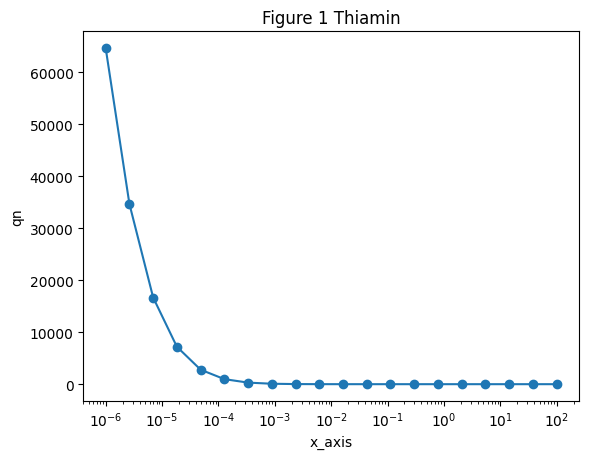

In [144]:
nutrient = thiamin
x_axis = [1e-06, 2.6366508987303555e-06, 6.951927961775606e-06, 1.8329807108324375e-05, 4.8329302385717524e-05, 0.00012742749857031334, 0.0003359818286283781, 0.0008858667904100823, 0.002335721469090121, 0.00615848211066026, 0.01623776739188721, 0.04281332398719396, 0.11288378916846883, 0.2976351441631313, 0.7847599703514607, 2.06913808111479, 5.455594781168514, 14.384498882876601, 37.92690190732246, 100.0]


qn=[]
fig_name = "Figure 1"
for i in x_axis:
    qn.append(qn_calculator(i,five_food_list,nutrient))
print(qn)
graph_plot_one(nutrient,x_axis,qn,fig_name)

PART 2

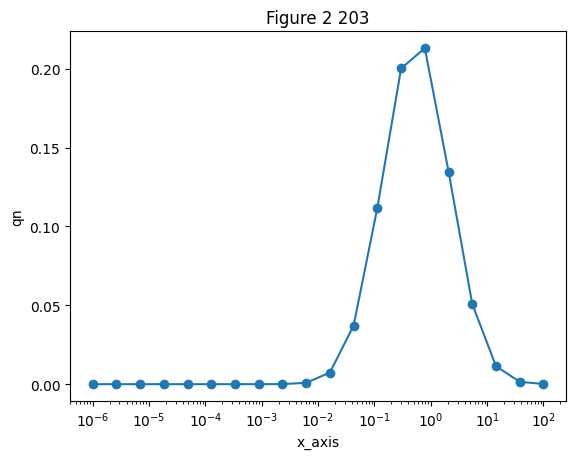

In [145]:
nutrient = protein
x_axis = [1e-06, 2.6366508987303555e-06, 6.951927961775606e-06, 1.8329807108324375e-05, 4.8329302385717524e-05, 0.00012742749857031334, 0.0003359818286283781, 0.0008858667904100823, 0.002335721469090121, 0.00615848211066026, 0.01623776739188721, 0.04281332398719396, 0.11288378916846883, 0.2976351441631313, 0.7847599703514607, 2.06913808111479, 5.455594781168514, 14.384498882876601, 37.92690190732246, 100.0] 
qn_all=[]
fig_name = "Figure 2"
for i in x_axis:
    qn_all.append(qn_calculator(i,data_list,nutrient))

graph_plot_one(nutrient,x_axis,qn_all,fig_name)

In [146]:
print(qn_calculator(1e-2,data_list,thiamin))

0.03114250067184624


[595.9355203009648, 2526.53275270234, 5973.001822872417, 7874.127017348775, 5788.342744466873, 2372.7288784546613, 542.3554982226053, 69.12927982787555, 4.913399439192923, 0.1947350674995654, 0.004303762658293698, 5.303890077802463e-05, 3.644876105938173e-07, 1.3967319917389452e-09, 2.9845952587417975e-12, 3.556312063415709e-15, 2.3629598110942038e-18, 8.754974020818196e-22, 1.8088203787591084e-25, 2.0839057689692167e-29]


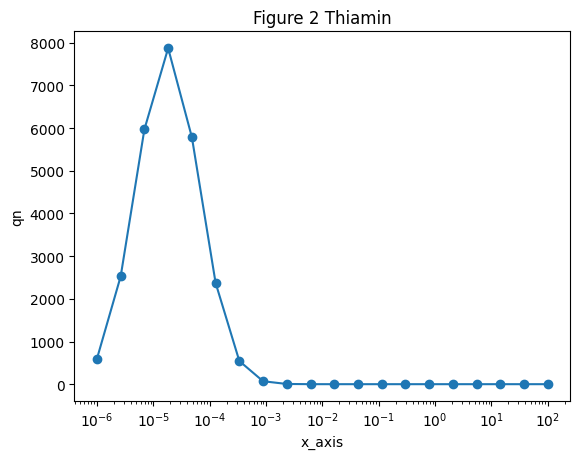

In [147]:
nutrient = thiamin
x_axis = [1e-06, 2.6366508987303555e-06, 6.951927961775606e-06, 1.8329807108324375e-05, 4.8329302385717524e-05, 0.00012742749857031334, 0.0003359818286283781, 0.0008858667904100823, 0.002335721469090121, 0.00615848211066026, 0.01623776739188721, 0.04281332398719396, 0.11288378916846883, 0.2976351441631313, 0.7847599703514607, 2.06913808111479, 5.455594781168514, 14.384498882876601, 37.92690190732246, 100.0] 
qn_all=[]
fig_name = "Figure 2"
for i in x_axis:
    qn_all.append(qn_calculator(i,data_list,nutrient))
    
print(qn_all)

graph_plot_one(nutrient,x_axis,qn_all,fig_name)

ACROSS ALL FOODS

In [148]:

print(standard_deviation(data_list,thiamin))   #1.26543225 is the standard deviation acc to 4889 foods
print(standard_deviation(data_list,zinc))   #1.34545079 is the standard deviation acc to 4889 foods
print(standard_deviation(data_list,protein))   #1.34357727 is the standard deviation acc to 4889 foods
print(standard_deviation(data_list,gadoleic_acid))   #2.1041791 is the standard deviation acc to 4889 foods


# data

1.268586235209873
1.3455631498439125
1.3450027170698398
2.1002331173044397


In [149]:
l = np.array([standard_deviation(data_list,thiamin),standard_deviation(data_list,zinc),standard_deviation(data_list,protein),standard_deviation(data_list,gadoleic_acid)])
# avg = (standard_deviation(data,thiamin)+standard_deviation(data,zinc)+standard_deviation(data,protein)+standard_deviation(data,gadoleic_acid))/4
avg = np.mean(l)
sd = np.std(l)
print(sd)
print(avg)
print(l)

print("standard deviation of 4 nutrients: "+str(avg)+"+-"+str(sd))  #acc to data it is 1.66+-0.39
# avg

0.33942059932095375
1.5148463048570164
[1.26858624 1.34556315 1.34500272 2.10023312]
standard deviation of 4 nutrients: 1.5148463048570164+-0.33942059932095375


In [150]:
l=np.array([1.26543225,1.34545079,1.34357727,2.1041791])
avg = np.mean(l)
sd = np.std(l)
print(sd)
print(avg)

print("sd of 4 nutrients: "+str(avg)+"+-"+str(sd))  #acc to data it is 1.66+-0.39           


0.3418875172801219
1.5146598525
sd of 4 nutrients: 1.5146598525+-0.3418875172801219


In [151]:
print(skewness(data_list,thiamin))       #-0.035609511 is the skewness acc to 4889 foods
print(skewness(data_list,zinc))          #-0.445958592 is the skewness acc to 4889 foods
print(skewness(data_list,protein))       #-1.108838677 is the skewness acc to 4889 foods
print(skewness(data_list,gadoleic_acid)) #-1.094805201 is the skewness acc to 4889 foods


# A negative skewness value indicates that the distribution is skewed to the left, 
# with the tail on the left side of the distribution being longer or fatter compared to the right side.


-0.043316177036222675
-0.45108501905094134
-1.1131284003717072
-1.0928346274077914
